In [7]:
import nltk
import numpy as np
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [8]:
devfile = "../A1_Data/dev.json"
trainfile = "../A1_Data/train.json"

### Training Phase

In [9]:
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_labels.append(json_dump["ratings"])
f.close()

In [10]:
vectorizer = pickle.load(open("baseline_vectorizer.pickle","rb"))

In [11]:
feature_vector = pickle.load(open("baseline_tfidf_train_vector.pickle","rb"))

In [12]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", multi_class='multinomial', solver="lbfgs")

In [13]:
start = timeit.default_timer()
model.fit(feature_vector, train_labels)
print(timeit.default_timer()-start)

221.54250543599983


/home/deepanshu/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
pickle.dump(model,open("baseline_logist_model.pickle", "wb"))

### Some sanity checks

In [15]:
sanity_check = "Dishonest, untrustworthy, flaw-hiding dealership that is an embarrassment to the brand it bears"
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

1.0

In [16]:
sanity_check = "Excellent service. The staff is so friendly and always  willing to have conversations with their clients."
check_vector = vectorizer.transform([sanity_check]).toarray()
model.predict(check_vector)[0]

5.0

### Validation phase

In [17]:
dev_feature_vector = pickle.load(open("baseline_tfidf_dev_vector.pickle","rb"))

In [23]:
dev_labels = []
dev_data = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_labels.append(json_dump["ratings"])
    dev_data.append(json_dump["review"])
f.close()

In [24]:
conf_mat = np.zeros((5,5), dtype=int)
f = open("error_file","w")
for i in range(0,len(dev_labels),1000):
    fv = dev_feature_vector[i:i+1000].toarray()
    y_pred = model.predict(fv)
    conf_mat+= confusion_matrix(y_pred, dev_labels[i:i+1000])
    
    for p in range(1000):
        if  abs(y_pred[p]-dev_labels[i+p])>2:
            f.write("Gold: %.1f, Predicted: %.1f, Review: %s\n"%(dev_labels[i+p], y_pred[p], dev_data[i+p].replace('\n','\\n')))
conf_mat

array([[25122,  5475,  1861,   728,   991],
       [ 2408,  4948,  2457,   519,   209],
       [  848,  3860,  9255,  3971,   870],
       [  446,  1087,  6464, 21412, 10065],
       [  965,   769,  2079, 17376, 75815]])

In [25]:
print("Accuracy: \t",conf_mat.trace()/len(dev_data))
score = 0
for i in range(5):
    for j in range(5):
        score+=conf_mat[i][j]*((i-j)**2)
print("Cost: \t\t",score)

Accuracy: 	 0.68276
Cost: 		 131796


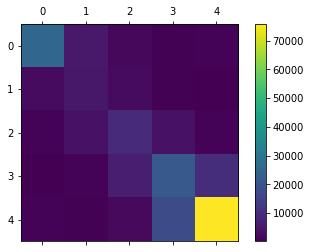

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
fig.colorbar(cax)
plt.savefig("Conf_Mat_Baseline.jpg")